# Problem 8: Complete Transformer Block - Interactive Notebook

Explore the full transformer block combining attention and feedforward layers.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# When finished, uncomment the following sentence and import your own solution
from solution import TransformerBlock
# from problem import TransformerBlock

torch.manual_seed(42)
plt.rcParams['figure.figsize'] = (14, 10)
print('Setup complete!')

Setup complete!


## Create and Inspect Transformer Block

In [2]:
# Create transformer block
n_embd, n_head, n_positions = 768, 12, 1024
block = TransformerBlock(
    n_embd=n_embd,
    n_head=n_head,
    n_positions=n_positions,
    attn_pdrop=0.0,
    resid_pdrop=0.0,
)
block.eval()

print('Transformer Block Structure:')
print(f'  Input dimension: {n_embd}')
print(f'  Number of attention heads: {n_head}')
print(f'  Head dimension: {n_embd // n_head}')
print(f'  FFN inner dimension: {block.mlp.c_fc.out_features} (4x expansion)')
print(f'  Max sequence length: {n_positions}')
print(f'\nTotal parameters: {sum(p.numel() for p in block.parameters()):,}')

Transformer Block Structure:
  Input dimension: 768
  Number of attention heads: 12
  Head dimension: 64
  FFN inner dimension: 3072 (4x expansion)
  Max sequence length: 1024

Total parameters: 7,087,872


## Visualize Information Flow Through Block

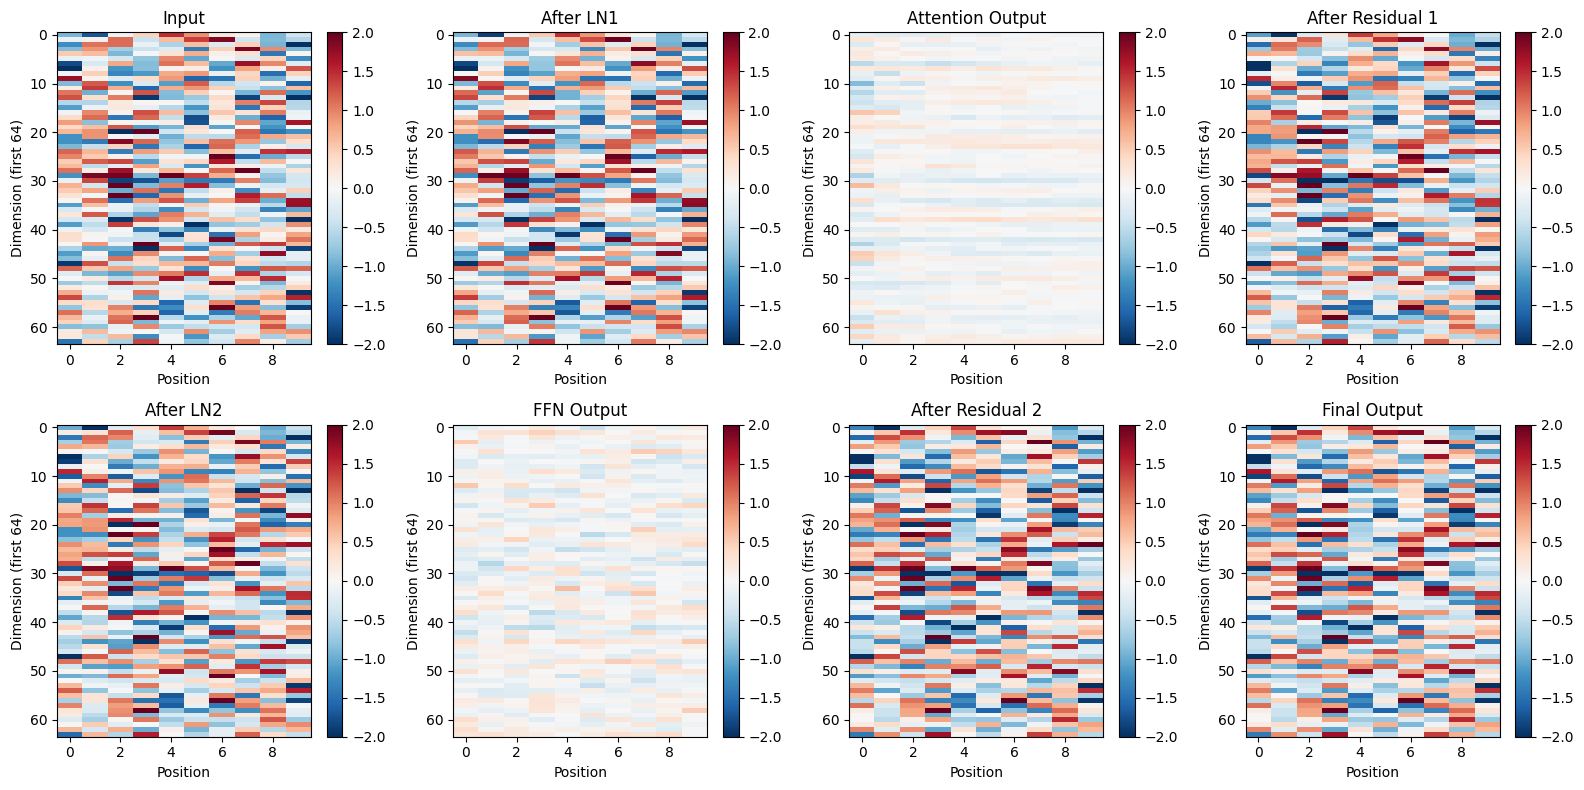

Information flows through: Input → LN1 → Attn → Res1 → LN2 → FFN → Res2 → Output


In [3]:
# Track activations through the block
seq_len = 10
x = torch.randn(1, seq_len, n_embd)

with torch.no_grad():
    # Step by step through the block
    x1_ln = block.ln_1(x)  # Layer norm 1
    x1_attn = block.attn(x1_ln)  # Attention
    x1_res = x + x1_attn  # Residual 1
    
    x2_ln = block.ln_2(x1_res)  # Layer norm 2
    x2_mlp = block.mlp(x2_ln)  # Feedforward
    x2_res = x1_res + x2_mlp  # Residual 2
    
    # Full forward pass
    output = block(x)

# Verify our manual computation matches
assert torch.allclose(x2_res, output, atol=1e-5)

# Visualize activations at each stage
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

stages = [
    (x, 'Input'),
    (x1_ln, 'After LN1'),
    (x1_attn, 'Attention Output'),
    (x1_res, 'After Residual 1'),
    (x2_ln, 'After LN2'),
    (x2_mlp, 'FFN Output'),
    (x2_res, 'After Residual 2'),
    (output, 'Final Output'),
]

for idx, (tensor, title) in enumerate(stages):
    ax = axes[idx // 4, idx % 4]
    # Show first 64 dimensions for visibility
    im = ax.imshow(tensor.squeeze()[:, :64].T.numpy(), aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(title)
    ax.set_xlabel('Position')
    ax.set_ylabel('Dimension (first 64)')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print('Information flows through: Input → LN1 → Attn → Res1 → LN2 → FFN → Res2 → Output')

## Visualize Residual Connection Impact

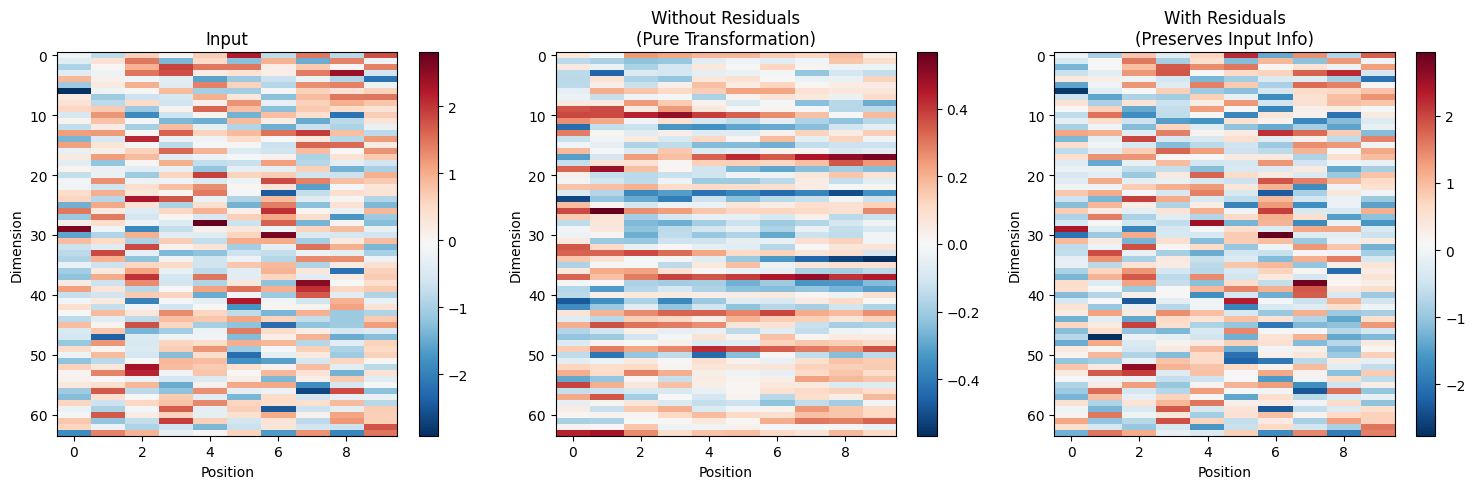

Residual connections help preserve information from input!


In [4]:
# Compare with and without residual connections
x_test = torch.randn(1, 10, 64)

# Small block for visualization
small_block = TransformerBlock(
    n_embd=64,
    n_head=4,
    n_positions=128,
    attn_pdrop=0.0,
    resid_pdrop=0.0,
)
small_block.eval()

with torch.no_grad():
    # With residual
    output_with_residual = small_block(x_test)
    
    # Without residual (just the transformations)
    x_ln1 = small_block.ln_1(x_test)
    x_attn = small_block.attn(x_ln1)
    x_ln2 = small_block.ln_2(x_attn)
    output_no_residual = small_block.mlp(x_ln2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

im1 = axes[0].imshow(x_test.squeeze().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[0].set_title('Input')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Dimension')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(output_no_residual.squeeze().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[1].set_title('Without Residuals\n(Pure Transformation)')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Dimension')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(output_with_residual.squeeze().T.numpy(), aspect='auto', cmap='RdBu_r')
axes[2].set_title('With Residuals\n(Preserves Input Info)')
axes[2].set_xlabel('Position')
axes[2].set_ylabel('Dimension')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print('Residual connections help preserve information from input!')

## Compare Single Block vs Stacked Blocks

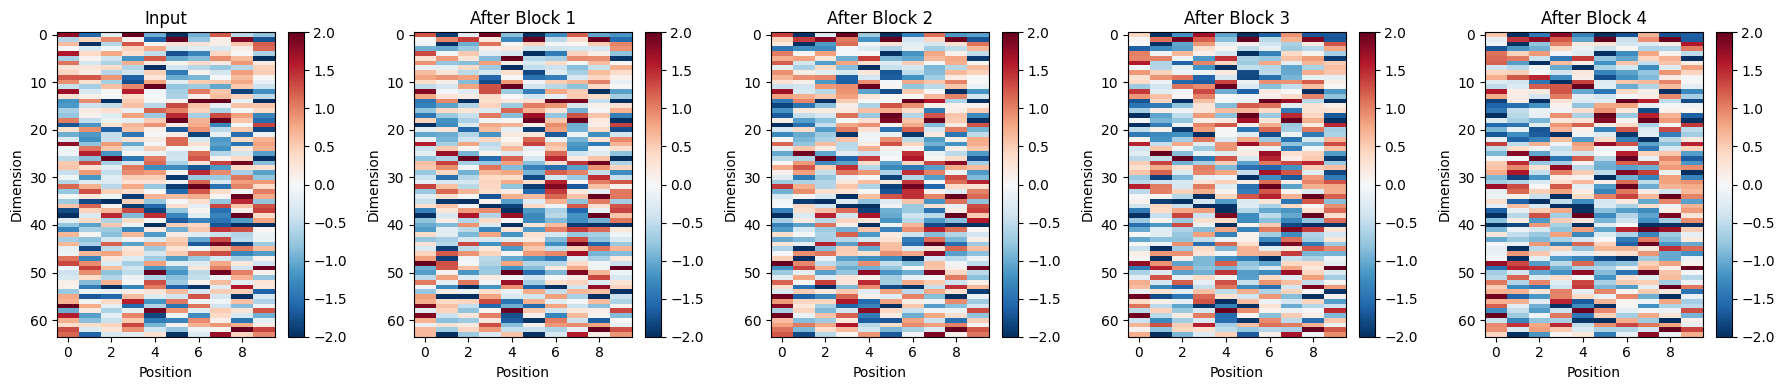

Each block refines the representation!
GPT-2 small uses 12 blocks, medium uses 24, large uses 36, xl uses 48!


In [5]:
# Create multiple blocks
n_embd = 64
blocks = nn.ModuleList([
    TransformerBlock(
        n_embd=n_embd,
        n_head=4,
        n_positions=128,
        attn_pdrop=0.0,
        resid_pdrop=0.0,
    )
    for _ in range(4)
])

for block in blocks:
    block.eval()

x = torch.randn(1, 10, n_embd)

# Pass through blocks one by one
outputs = [x]
current = x
with torch.no_grad():
    for block in blocks:
        current = block(current)
        outputs.append(current)

# Visualize progression
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for i, (output, ax) in enumerate(zip(outputs, axes)):
    im = ax.imshow(output.squeeze().T.numpy(), aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    if i == 0:
        ax.set_title('Input')
    else:
        ax.set_title(f'After Block {i}')
    ax.set_xlabel('Position')
    ax.set_ylabel('Dimension')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print('Each block refines the representation!')
print('GPT-2 small uses 12 blocks, medium uses 24, large uses 36, xl uses 48!')

## Analyze Gradient Flow Through Stacked Blocks

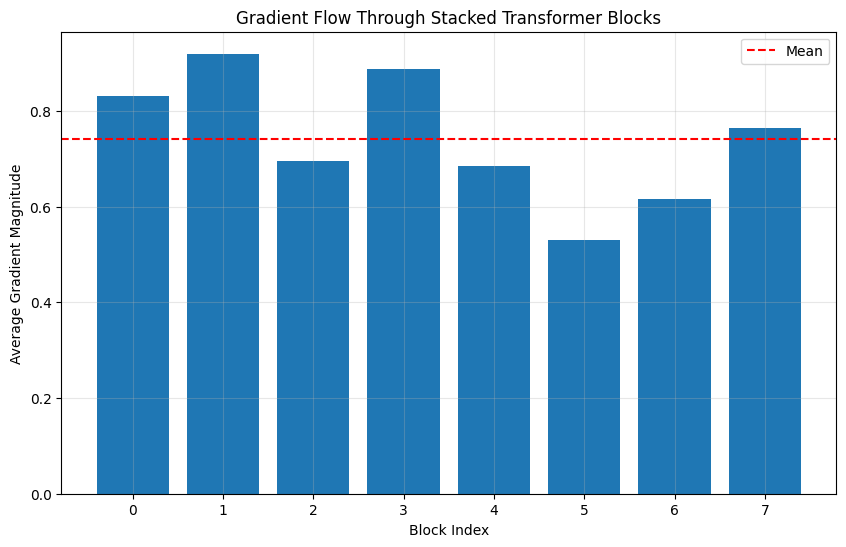

Gradient magnitudes relatively uniform: 0.126267 std dev
Residual connections enable stable gradient flow through deep networks!


In [6]:
# Test gradient flow through multiple blocks
n_blocks = 8
n_embd = 64

blocks = nn.ModuleList([
    TransformerBlock(
        n_embd=n_embd,
        n_head=4,
        n_positions=128,
        attn_pdrop=0.0,
        resid_pdrop=0.0,
    )
    for _ in range(n_blocks)
])

x = torch.randn(1, 5, n_embd, requires_grad=True)

# Forward pass
current = x
for block in blocks:
    current = block(current)

# Backward pass
loss = current.sum()
loss.backward()

# Measure gradient magnitude at each block
grad_magnitudes = []
for i, block in enumerate(blocks):
    # Check layer norm 1 gradient as proxy for block gradient
    grad_mag = block.ln_1.weight.grad.abs().mean().item()
    grad_magnitudes.append(grad_mag)

plt.figure(figsize=(10, 6))
plt.bar(range(n_blocks), grad_magnitudes)
plt.xlabel('Block Index')
plt.ylabel('Average Gradient Magnitude')
plt.title('Gradient Flow Through Stacked Transformer Blocks')
plt.axhline(y=np.mean(grad_magnitudes), color='r', linestyle='--', label='Mean')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f'Gradient magnitudes relatively uniform: {np.std(grad_magnitudes):.6f} std dev')
print('Residual connections enable stable gradient flow through deep networks!')

## Parameter Breakdown

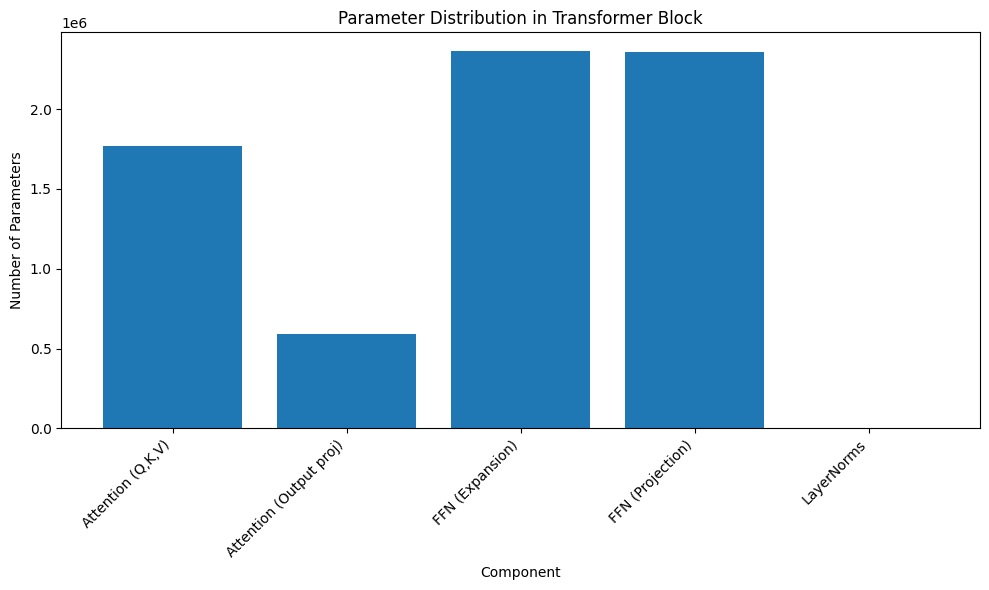


Parameter breakdown:
  Attention (Q,K,V): 1,771,776 (25.0%)
  Attention (Output proj): 590,592 (8.3%)
  FFN (Expansion): 2,362,368 (33.3%)
  FFN (Projection): 2,360,064 (33.3%)
  LayerNorms: 3,072 (0.0%)

Total: 7,087,872 parameters per block

GPT-2 small (12 blocks): ~85.1M parameters in transformer blocks


In [7]:
# Analyze parameter distribution
block = TransformerBlock(
    n_embd=768,
    n_head=12,
    n_positions=1024,
)

param_counts = {
    'Attention (Q,K,V)': block.attn.c_attn.weight.numel() + block.attn.c_attn.bias.numel(),
    'Attention (Output proj)': block.attn.c_proj.weight.numel() + block.attn.c_proj.bias.numel(),
    'FFN (Expansion)': block.mlp.c_fc.weight.numel() + block.mlp.c_fc.bias.numel(),
    'FFN (Projection)': block.mlp.c_proj.weight.numel() + block.mlp.c_proj.bias.numel(),
    'LayerNorms': sum(p.numel() for p in block.ln_1.parameters()) + 
                  sum(p.numel() for p in block.ln_2.parameters()),
}

plt.figure(figsize=(10, 6))
plt.bar(param_counts.keys(), param_counts.values())
plt.xlabel('Component')
plt.ylabel('Number of Parameters')
plt.title('Parameter Distribution in Transformer Block')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

total = sum(param_counts.values())
print('\nParameter breakdown:')
for name, count in param_counts.items():
    print(f'  {name}: {count:,} ({100*count/total:.1f}%)')
print(f'\nTotal: {total:,} parameters per block')
print(f'\nGPT-2 small (12 blocks): ~{total * 12 / 1e6:.1f}M parameters in transformer blocks')

## Verify Your Implementation

In [8]:
# Quick verification
block = TransformerBlock(
    n_embd=768,
    n_head=12,
    n_positions=1024,
)

x_test = torch.randn(2, 10, 768)
output = block(x_test)

print('✓ TransformerBlock implemented')
print('✓ Two layer norms (pre-norm architecture)')
print('✓ Causal multi-head attention')
print('✓ Position-wise feedforward network')
print('✓ Two residual connections')
print(f'✓ Shape preserved: {x_test.shape} → {output.shape}')
print('\n✅ Complete transformer block working!')
print('\nRun "uv run pytest test_transformer_block.py -v" for complete validation.')

✓ TransformerBlock implemented
✓ Two layer norms (pre-norm architecture)
✓ Causal multi-head attention
✓ Position-wise feedforward network
✓ Two residual connections
✓ Shape preserved: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])

✅ Complete transformer block working!

Run "uv run pytest test_transformer_block.py -v" for complete validation.
